# Bed availability forecasting:
Dataset provides us the number of filled beds on each date for the span of 1 year.
We have to forecast the availablity of hospital beds for the next one month.

#### Importing required libraries 

In [1]:
import pandas as pd #DataFrame functions
from numpy import array # Array 

import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization
import plotly.express as px #visualization
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose #Seasonality charts
import statsmodels.graphics.tsaplots as tsa_plots #ACF/PACF plots

from sklearn.impute import KNNImputer #Imputaion

from statsmodels.tsa.stattools import adfuller #Statistical test for stationarity

from sklearn.metrics import mean_squared_error #Rmse
from math import sqrt #RMSE

import statsmodels.formula.api as smf #Linear Regression
from statsmodels.tsa.ar_model import AutoReg #AR
from statsmodels.tsa.arima.model import ARIMA #ARIMA
from pmdarima import auto_arima #Auto ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #Simple Exponential Smoothening
from statsmodels.tsa.holtwinters import Holt #Holt's Trend Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing #Holt's winter Smoothing

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, GRU
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import warnings
warnings.filterwarnings('ignore') #To ignore warnings

#### Importing the dataset

In [2]:
data = pd.read_csv('Beds_Occupied.csv')
data

collection_date  Total Inpatient Beds
0        15-06-2020                   293
1        16-06-2020                   295
2        17-06-2020                   290
3        18-06-2020                   291
4        19-06-2020                   288
..              ...                   ...
354      11-06-2021                   312
355      12-06-2021                   212
356      13-06-2021                   299
357      14-06-2021                   202
358      15-06-2021                   220

[359 rows x 2 columns]

In [3]:
print('The total number of records is', data.shape[0])

The total number of records is 359


#### EDA 

Data Type Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   collection_date       359 non-null    object
 1   Total Inpatient Beds  359 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


In [5]:
#Since the datatype of 'collection_date' is object, we are converting it to datetime.
data['collection_date'] = pd.to_datetime(data['collection_date'], format='%d-%m-%Y')
data.head()

collection_date  Total Inpatient Beds
0      2020-06-15                   293
1      2020-06-16                   295
2      2020-06-17                   290
3      2020-06-18                   291
4      2020-06-19                   288

In [6]:
# Checking the datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   collection_date       359 non-null    datetime64[ns]
 1   Total Inpatient Beds  359 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.7 KB


Feature Engineering

In [7]:
#Creating a new column in dataframe showing the availability of beds using a UDF
def avail(beds):
    available_beds = 900-beds
    return available_beds

data['availability']=data['Total Inpatient Beds'].apply(avail)
data.head()

collection_date  Total Inpatient Beds  availability
0      2020-06-15                   293           607
1      2020-06-16                   295           605
2      2020-06-17                   290           610
3      2020-06-18                   291           609
4      2020-06-19                   288           612

In [8]:
# Dropping the Total Inpatient Beds feature in the dataframe
data = data.drop('Total Inpatient Beds', axis = 1)
data.head()

collection_date  availability
0      2020-06-15           607
1      2020-06-16           605
2      2020-06-17           610
3      2020-06-18           609
4      2020-06-19           612

Missing Values

In [9]:
#Lets us find the missing dates
range_dates = pd.date_range(start=data.collection_date.min(), end=data.collection_date.max())
missing_dates = range_dates.difference(data['collection_date'])

print('The missing dates are \n',missing_dates)
print('The number of missing dates are', len(missing_dates))

The missing dates are 
 DatetimeIndex(['2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29',
               '2021-05-14', '2021-05-15', '2021-05-16'],
              dtype='datetime64[ns]', freq=None)
The number of missing dates are 7


In [10]:
#Filling the missing dates in the dataframe
data = data.set_index('collection_date').reindex(range_dates).rename_axis('date').reset_index()

<AxesSubplot:>

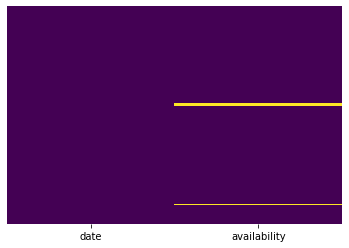

In [11]:
# Visualizing the missing values using a heatmap
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
# Filling the NaN values of availability column using K-Nearest Neighbors
imputer = KNNImputer(n_neighbors=3)
df = imputer.fit_transform(data[['availability']])

avail_df = pd.DataFrame(df, columns=['Availability']) #Array ouput of imputer is converted in to a DataFrame

data = data.assign(availability=avail_df['Availability']) #Then replacing the imputed column to our original dataframe

In [13]:
#Let us check for duplicated records
print('The number of duplicated dates',data.duplicated('date').sum())
data[data.duplicated('date')]

The number of duplicated dates 0


Empty DataFrame
Columns: [date, availability]
Index: []

Visual Analysis

In [14]:
# Setting date as index
data = data.set_index('date')
data.head()

availability
date                    
2020-06-15         607.0
2020-06-16         605.0
2020-06-17         610.0
2020-06-18         609.0
2020-06-19         612.0

In [15]:
data.shape

(366, 1)

In [16]:
#Visualizing the data on a line plot
px.line(data, x=data.index, y='availability', title='Available beds over the year')

In [17]:
# Visualizing the data in a scatter plot
px.scatter(data, x=data.index,y='availability', title='Available beds over the year')

<function matplotlib.pyplot.show(close=None, block=None)>

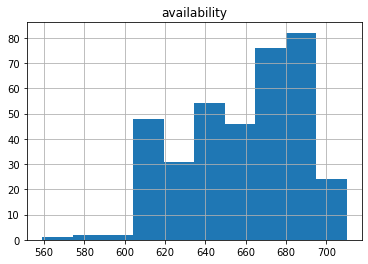

In [18]:
# Histogram
data.hist()
plt.show

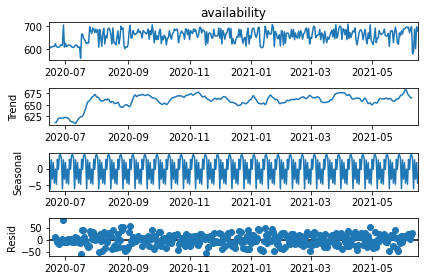

In [19]:
# Visualizing trend, seasonality and resid
seasonal_decompose(data.availability, period=12).plot()
plt.show()

Text(0.5, 1.0, 'Rolling 30 day average')

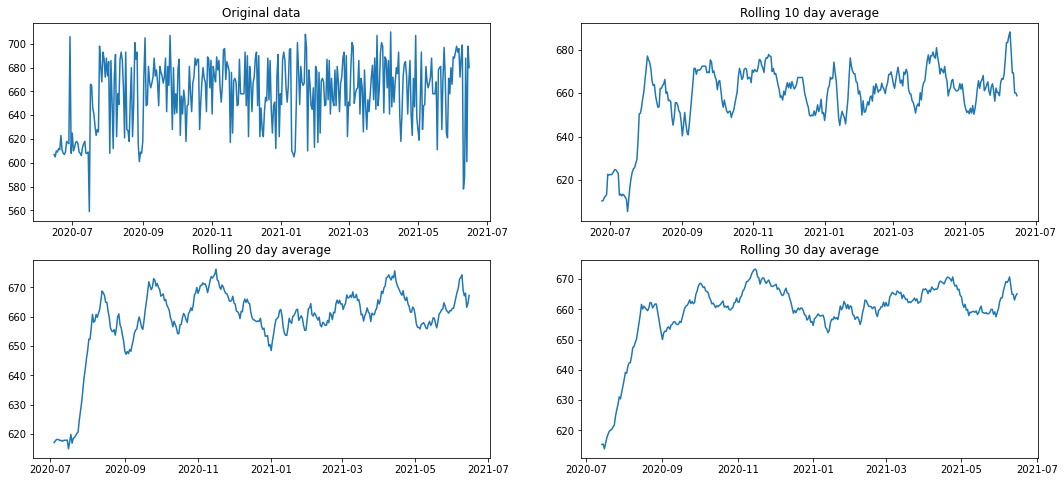

In [20]:
# Plotting the data and comparing with moving averages
fig, ax=plt.subplots(2,2,figsize=(18,8))

# Original data plot
ax[0,0].plot(data)
ax[0,0].set_title('Original data')

# Moving average with window 10
data_10 = data.rolling(window = 10).mean()
ax[0,1].plot(data_10)
ax[0,1].set_title('Rolling 10 day average')

# Moving average plot with window 20
data_20 = data.rolling(window=20).mean()
ax[1,0].plot(data_20)
ax[1,0].set_title('Rolling 20 day average')

# Moving average plot with window 30
data_30 = data.rolling(window=30).mean()
ax[1,1].plot(data_30)
ax[1,1].set_title('Rolling 30 day average')

Text(0.5, 1.0, 'Lag plot')

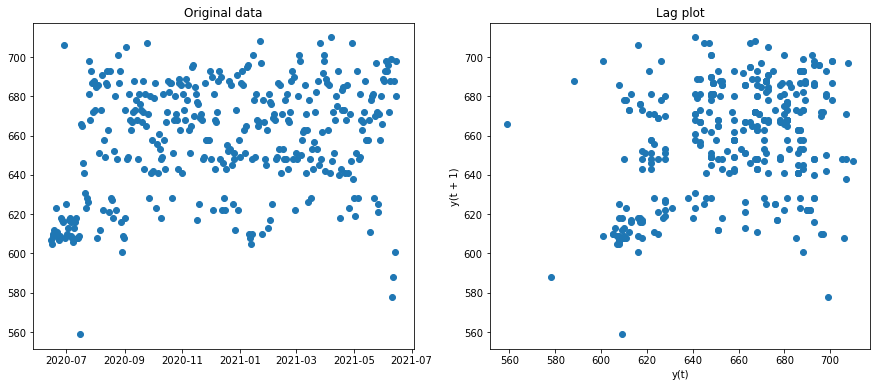

In [21]:
# Lag plots
plt.figure(figsize=(15,6))

# Original data
plt.subplot(1,2,1)
plt.scatter(data.index,data.availability)
plt.title('Original data')

# lag value = 1
plt.subplot(1,2,2)
pd.plotting.lag_plot(data,lag=1)
plt.title('Lag plot')

#### Checking for Stationarity 

Statistical and Visual Method

In [22]:
#Checking the rolling average and standard deviation for data
rollingmean = data.rolling(window =30).mean()
rollingstd = data.rolling(window =30).std()

In [23]:
print('The moving average mean for last 10 days:')
rollingmean.tail(10)

The moving average mean for last 10 days:


availability
date                    
2021-06-06    669.201671
2021-06-07    668.901671
2021-06-08    669.568338
2021-06-09    670.768338
2021-06-10    667.801671
2021-06-11    665.001671
2021-06-12    665.001671
2021-06-13    663.101114
2021-06-14    664.433890
2021-06-15    665.166667

In [24]:
print('The moving average standard deviation for last 10 days:')
rollingstd.tail(10)

The moving average standard deviation for last 10 days:


availability
date                    
2021-06-06     22.803265
2021-06-07     22.701669
2021-06-08     22.966398
2021-06-09     23.544592
2021-06-10     29.008808
2021-06-11     32.440555
2021-06-12     32.440555
2021-06-13     34.470557
2021-06-14     35.035525
2021-06-15     35.126455

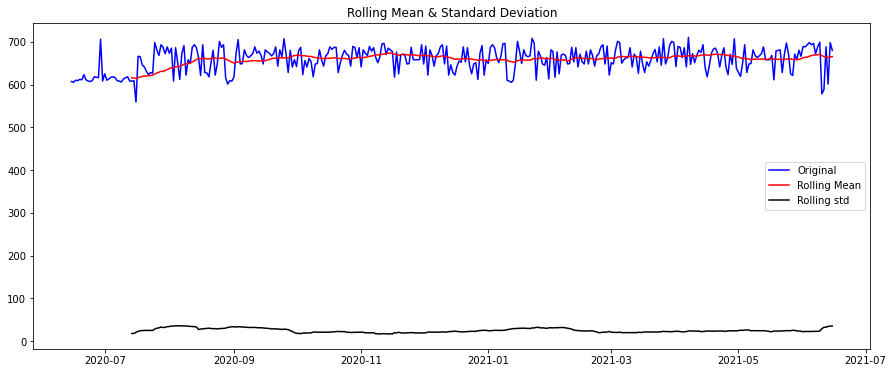

In [25]:
# Visual represntation
plt.figure(figsize=(15,6))
plt.plot(data ,color ='blue',label ='Original')
plt.plot(rollingmean , color = 'red', label = 'Rolling Mean')
plt.plot(rollingstd , color = 'black', label = 'Rolling std')
plt.legend(loc ='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Augumented Dickey-Fuller Test Method

In [26]:
adft = adfuller(data.availability)

dfoutput = pd.Series(adft[0:4] ,
                     index = ['Test Statistics', 'p-value','#Lags used','Number of Observations Used'])

for key,value in adft[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
pd.DataFrame(dfoutput, columns=['Values'])

Values
Test Statistics             -5.824878e+00
p-value                      4.101437e-07
#Lags used                   4.000000e+00
Number of Observations Used  3.610000e+02
Critical Value (1%)         -3.448595e+00
Critical Value (5%)         -2.869580e+00
Critical Value (10%)        -2.571053e+00

#### Model Building 

In [27]:
# Train Test Split
train = data[:333]
test = data[333:]
print(train.shape)
print(test.shape)

(333, 1)
(33, 1)


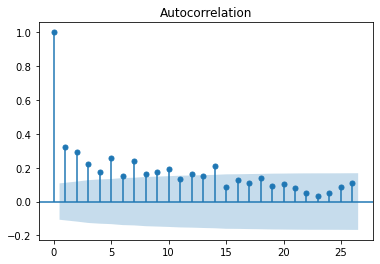

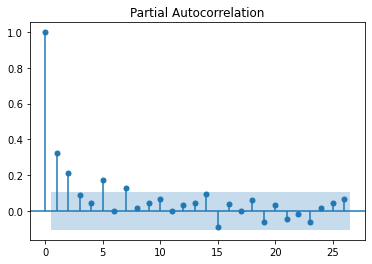

In [28]:
#ACF & PACF plots for order of AR and MA models.
tsa_plots.plot_acf(train)
tsa_plots.plot_pacf(train)
plt.show()

1. Autoregressive Moving Average (ARMA) Method

In [29]:
# Forecasts the next step in the sequence as a linear function of the observations and residual errors at prior time steps
ARMA_train = train.copy()
ARMA_test = test.copy()

ARMA_model = ARIMA(train, order=(13,0,9)).fit()

#Prediction
ARMA_train['forecasts'] = ARMA_model.predict(0,len(train))
ARMA_test['forecasts'] = ARMA_model.predict(len(train),(len(data)-1))
ARMA_forecast = ARMA_model.forecast(63)

# Evaluation
ARMA_train_score = sqrt(mean_squared_error(ARMA_train.availability,ARMA_train.forecasts))
ARMA_test_score = sqrt(mean_squared_error(ARMA_test.availability,ARMA_test.forecasts))
print(ARMA_train_score)
print(ARMA_test_score)

24.24622576234261
33.57215951767411


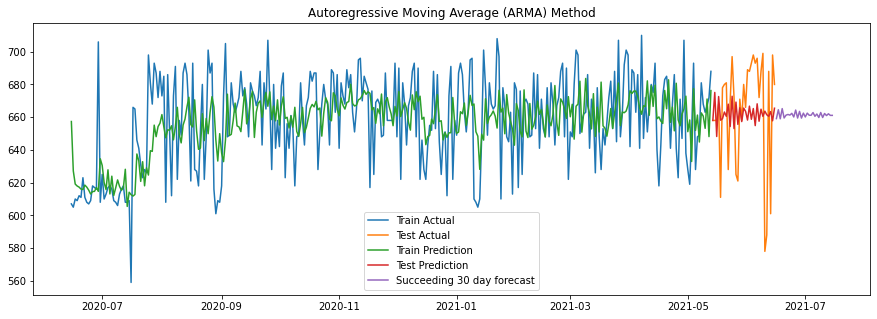

In [30]:
plt.figure(figsize=(15,5))
plt.plot(train,label='Train Actual')
plt.plot(test,label='Test Actual')
plt.plot(ARMA_train.forecasts,label='Train Prediction')
plt.plot(ARMA_test.forecasts,label='Test Prediction')
plt.plot(ARMA_forecast[33:],label='Succeeding 30 day forecast')
plt.title("Autoregressive Moving Average (ARMA) Method", loc='center')
plt.legend(loc='best')
plt.show()

2. Autoregressive Integrated Moving Average (ARIMA) Method

In [31]:
# Forecasts the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps
ARIMA_train = train.copy()
ARIMA_test = test.copy()

ARIMA_model = ARIMA(train, order=(13,1,9)).fit()

# Prediction
ARIMA_train['forecasts'] = ARIMA_model.predict(0,len(train))
ARIMA_test['forecasts'] = ARIMA_model.predict(len(train),(len(data)-1))
ARIMA_forecast = ARIMA_model.forecast(63)

# Evaluation
ARIMA_train_score = sqrt(mean_squared_error(ARIMA_train.availability[1:],ARIMA_train.forecasts[1:]))
ARIMA_test_score = sqrt(mean_squared_error(ARIMA_test.availability,ARIMA_test.forecasts))
print('Train error:',ARIMA_train_score)
print('Test error:',ARIMA_test_score)

Train error: 24.26720314267382
Test error: 32.91035127305132


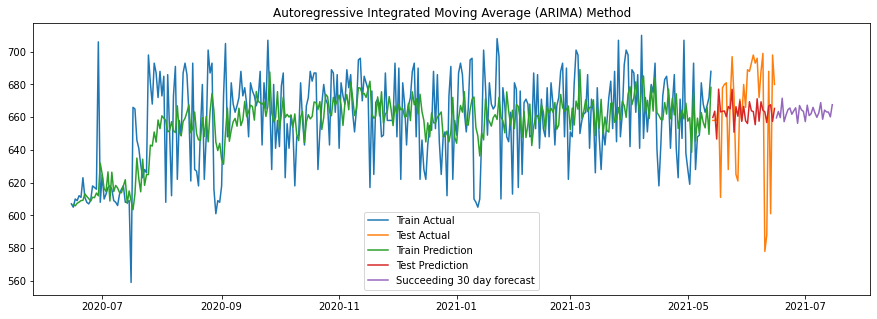

In [32]:
plt.figure(figsize=(15,5))
plt.plot(train,label='Train Actual')
plt.plot(test,label='Test Actual')
plt.plot(ARIMA_train.forecasts[1:],label='Train Prediction')
plt.plot(ARIMA_test.forecasts,label='Test Prediction')
plt.plot(ARIMA_forecast[33:],label='Succeeding 30 day forecast')
plt.title("Autoregressive Integrated Moving Average (ARIMA) Method", loc='center')
plt.legend(loc='best')
plt.show()

3. Seasonal Autoregressive Integrated Moving-Average (SARIMA) Method

In [33]:
# Forecasts the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.
SARIMA_train = train.copy()
SARIMA_test = test.copy()

SARIMA_model = SARIMAX(train, order=(13,0,9), seasonal_order=(0,0,4,12)).fit()

# Prediction
SARIMA_train['forecasts'] = SARIMA_model.predict(0,len(train))
SARIMA_test['forecasts'] = SARIMA_model.predict(len(train),(len(data)-1))
SARIMA_forecast = SARIMA_model.forecast(63)

# Evaluation
SARIMA_train_score = sqrt(mean_squared_error(SARIMA_train.availability[1:],SARIMA_train.forecasts[1:]))
SARIMA_test_score = sqrt(mean_squared_error(SARIMA_test.availability,SARIMA_test.forecasts))
print('Train error:',SARIMA_train_score)
print('Test error:',SARIMA_test_score)

Train error: 24.501758500372006
Test error: 32.50499804597215


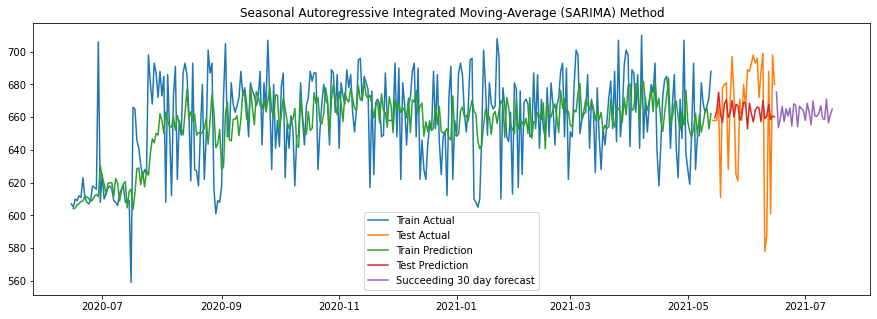

In [34]:
plt.figure(figsize=(15,5))
plt.plot(train,label='Train Actual')
plt.plot(test,label='Test Actual')
plt.plot(SARIMA_train.forecasts[1:],label='Train Prediction')
plt.plot(SARIMA_test.forecasts[1:],label='Test Prediction')
plt.plot(SARIMA_forecast[33:],label='Succeeding 30 day forecast')
plt.title("Seasonal Autoregressive Integrated Moving-Average (SARIMA) Method", loc='center')
plt.legend(loc='best')
plt.show()

4. Simple Exponential Smoothing (SES) Method

In [35]:
#Forecasts the next time step as an exponentially weighted linear function of observations at prior time steps
SES_train = train.copy()
SES_test = test.copy()

SES_model = SimpleExpSmoothing(train).fit()

#Prediction
SES_train['forecasts'] = SES_model.predict(0,len(train))
SES_test['forecasts'] = SES_model.predict(len(train),(len(data)-1))
SES_forecast = SES_model.forecast(63)

# Evaluation
SES_train_score = sqrt(mean_squared_error(SES_train.availability,SES_train.forecasts))
SES_test_score = sqrt(mean_squared_error(SES_test.availability,SES_test.forecasts))
print('Train error:',SES_train_score)
print('Test error:',SES_test_score)

Train error: 25.3661336248039
Test error: 32.99736792662905


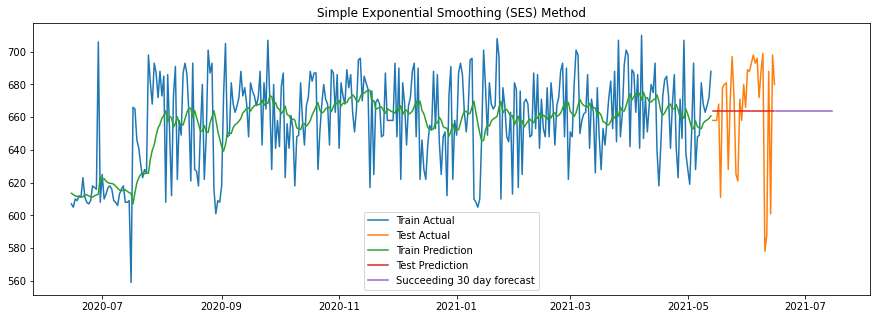

In [36]:
plt.figure(figsize=(15,5))
plt.plot(train,label='Train Actual')
plt.plot(test,label='Test Actual')
plt.plot(SES_train.forecasts,label='Train Prediction')
plt.plot(SES_test.forecasts,label='Test Prediction')
plt.plot(SES_forecast[33:],label='Succeeding 30 day forecast')
plt.title("Simple Exponential Smoothing (SES) Method", loc='center')
plt.legend(loc='best')
plt.show()

5. Holt's Winter Method

In [37]:
holts_winter_train = train.copy()
holts_winter_test = test.copy()

holts_winter_model = ExponentialSmoothing(train,seasonal="mul",seasonal_periods=7).fit()

#Prediction
holts_winter_train['forecasts'] = holts_winter_model.predict(start=holts_winter_train.index[0],end=holts_winter_train.index[-1])
holts_winter_test['forecasts'] = holts_winter_model.predict(len(train),(len(data)-1))
holts_winter_forecast = holts_winter_model.forecast(63)

# Evaluation
holts_winter_train_score = sqrt(mean_squared_error(holts_winter_train.availability[1:],holts_winter_train.forecasts[1:]))
holts_winter_test_score = sqrt(mean_squared_error(holts_winter_test.availability,holts_winter_test.forecasts))
print('Train error:',holts_winter_train_score)
print('Test error:',holts_winter_test_score)

Train error: 25.18927514040143
Test error: 32.491563925974326


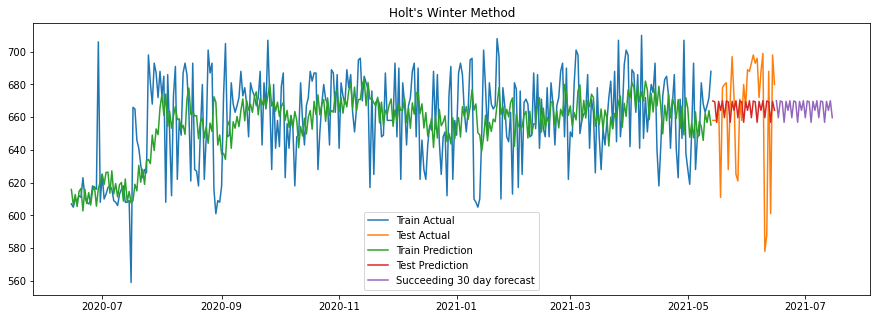

In [38]:
plt.figure(figsize=(15,5))
plt.plot(train,label='Train Actual')
plt.plot(test,label='Test Actual')
plt.plot(holts_winter_train.forecasts,label='Train Prediction')
plt.plot(holts_winter_test.forecasts,label='Test Prediction')
plt.plot(holts_winter_forecast[33:],label='Succeeding 30 day forecast')
plt.title("Holt's Winter Method", loc='center')
plt.legend(loc='best')
plt.show()

####  Model Evaluation

In [39]:
# Comparing the evaluation scores
tab1={"model":pd.Series(['ARMA Method','ARIMA Method','SARIMA Method','SES Method','Holts Winter Method']),
   "Train_RMSE":[ARMA_train_score,ARIMA_train_score,SARIMA_train_score,SES_train_score,holts_winter_train_score],
     "Test_RMSE":[ARMA_test_score,ARIMA_test_score,SARIMA_test_score,SES_test_score,holts_winter_test_score]}

table1=pd.DataFrame(tab1)
table1

model  Train_RMSE  Test_RMSE
0          ARMA Method   24.246226  33.572160
1         ARIMA Method   24.267203  32.910351
2        SARIMA Method   24.501759  32.504998
3           SES Method   25.366134  32.997368
4  Holts Winter Method   25.189275  32.491564

In [40]:
colors = ['green',] * 5
colors[2] = 'crimson'
go.Figure(data=[go.Bar(
            x=table1.Train_RMSE, y=table1.model,
            text=round(table1.Train_RMSE,2),
            textposition='auto', orientation='h',
            marker_color=colors
        )]).update_layout(barmode='stack', yaxis={'categoryorder':'total descending'})

In [41]:
color = ['green',] * 5
color[2] = 'crimson'
go.Figure(data=[go.Bar(
            x=table1.Test_RMSE, y=table1.model,
            text=round(table1.Test_RMSE,2),
            textposition='auto', orientation='h',
            marker_color=color
        )]).update_layout(barmode='stack', yaxis={'categoryorder':'total descending'}).show()

<AxesSubplot:xlabel='Train_RMSE', ylabel='model'>

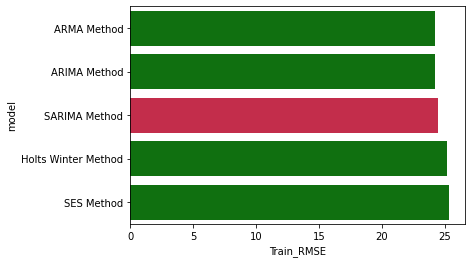

In [42]:
colors = ['green',] * 5
colors[2] = 'crimson'
sns.barplot(y=table1.model,x=table1.Train_RMSE, order = table1.sort_values('Train_RMSE',ascending=True).model,palette=colors)

<AxesSubplot:xlabel='Test_RMSE', ylabel='model'>

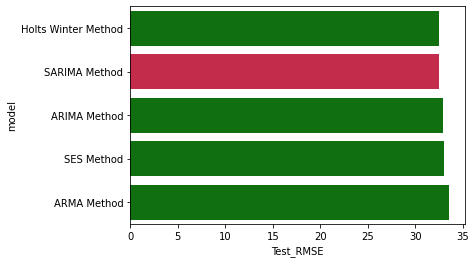

In [43]:
colors = ['green',] * 5
colors[1] = 'crimson'
sns.barplot(y=table1.model,x=table1.Test_RMSE, order = table1.sort_values('Test_RMSE',ascending=True).model,palette=colors)